# 🎬 Movie Box Office Prediction — Indian Film Dataset

This project predicts the **Worldwide Box Office Collection (₹ crores)** of Indian movies  
using **Linear Regression** on features like:
- Budget
- IMDb Rating
- Director and Star Power
- Genre & Language Scores
- Screen Count, Runtime, and Release Month

---

### 🔧 Workflow Steps
1. Import Libraries  
2. Load Dataset  
3. Handle Missing Columns  
4. Smart Language Encoding  
5. Genre Scoring  
6. Feature Preparation  
7. Train-Test Split & Scaling  
8. Model Training (Linear Regression)  
9. Model Evaluation & Visualization  
10. Prediction Function  
11. Example Prediction  

---


In [1]:
# 📦 Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## 📂 Step 1 — Load and Inspect Dataset

Make sure your dataset contains the following essential columns:
- **Budget**, **IMDb Rating**, **Worldwide Gross Collection**
- **Genre**, **Language**
- Optional: `runtime_min`, `screen_count`, `festive_month_flag`, etc.


In [3]:
# Example dataset load (adjust filename if needed)
df = pd.read_excel("finaldataset.xlsx")

# Quick check
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (601, 8)


,S.No.,Movie Name,Genre,IMDb Rating,Language,Budget,Domestic Collection,Worldwide Gross Collection
0,65,Dangal,"Action, Biography, Drama",8.3,Hindi,70.0,587.0,2122.3
1,313,Baahubali - The Conclusion,"Action, Drama",8.2,Telugu,250.0,1400.0,1810.0
2,349,RRR,"Action, Drama",7.8,Telugu,425.0,756.9,1250.9
3,348,K.G.F: Chapter 2,"Action, Crime, Drama",8.3,Kannada,150.0,815.9,1175.4
4,467,Jawan,"Action, Thriller",7.0,Hindi,300.0,640.8,1152.0


## 🧱 Step 2 — Ensure Required Columns Exist
We’ll make sure the essential columns exist and fill missing ones with zeros  
to prevent training issues later.


In [4]:
# Ensure all required columns exist
expected_cols = [
    "Budget", "IMDb Rating", "Worldwide Gross Collection",
    "runtime_min", "screen_count", "festive_month_flag",
    "star_power_index", "music_hype_index", "director_power_index"
]

for col in expected_cols:
    if col not in df.columns:
        if col in ["Budget", "Worldwide Gross Collection"]:
            raise RuntimeError(f"❌ Missing required column '{col}'.")
        df[col] = 0  # Safe default


## 🌍 Step 3 — Smart Multilingual Logic
To simulate realistic releases:
- **High Collection Movies** → All languages = 1 (Pan-India)
- **Medium Collection Movies** → 2–3 random languages = 1
- **Low Collection Movies** → Only 1 language = 1

Then we assign weights:
> Hindi = 2.0, Telugu = 1.6, Kannada = 1.3, Tamil = 1.2, Malayalam = 1.0


In [20]:
# ---------- 2. Smart Language Table Creation ----------
langs_to_create = ["Hindi", "Telugu", "Tamil", "Kannada", "Malayalam"]
for lang in langs_to_create:
    col = f"language_{lang}"
    if col not in df.columns:
        df[col] = 0

# Classify movies into high / medium / low tiers based on worldwide collection
worldwide = pd.to_numeric(df["Worldwide Gross Collection"], errors="coerce").fillna(0)
high_threshold = worldwide.quantile(0.80)
med_threshold = worldwide.quantile(0.40)

low_mask  = worldwide < med_threshold
med_mask  = (worldwide >= med_threshold) & (worldwide < high_threshold)
high_mask = worldwide >= high_threshold

# --- High-collection: all languages = 1 ---
df.loc[high_mask, [f"language_{l}" for l in langs_to_create]] = 1

# --- Medium-collection: randomly choose 2–3 languages ---
np.random.seed(42)
for idx in df[med_mask].index:
    chosen = np.random.choice(langs_to_create, size=np.random.randint(2, 4), replace=False)
    for lang in langs_to_create:
        df.loc[idx, f"language_{lang}"] = 1 if lang in chosen else 0

# --- Low-collection: one language (keep existing or random) ---
for idx in df[low_mask].index:
    subset = [f"language_{l}" for l in langs_to_create]
    if df.loc[idx, subset].sum() == 0:
        chosen = np.random.choice(langs_to_create)
        df.loc[idx, f"language_{chosen}"] = 1


## Step 3 — Compute Weighted Language Score
Each movie's language score is calculated using custom weights.


In [21]:
# ---------- 3. Compute Language Score ----------
weights = {
    "language_Hindi": 2.0,
    "language_Telugu": 1.6,
    "language_Kannada": 1.3,
    "language_Tamil": 1.2,
    "language_Malayalam": 1.0
}
df["language_score"] = 0.0
for col, w in weights.items():
    df["language_score"] += w * df.get(col, 0)


## Step 4 — Build Genre Score

Weighted importance for genres:  
Action (2.0) > Thriller (1.6) > Drama (1.3) > Comedy (1.1) > Adventure (1.0)


In [22]:
# ---------- 4. Build Genre Score ----------
top_genres = ["Action", "Thriller", "Drama", "Comedy", "Adventure"]
for g in top_genres:
    col = f"genre_{g}"
    if col not in df.columns:
        df[col] = df["Genre"].astype(str).str.contains(g, case=False, na=False).astype(int)

genre_weights = {
    "genre_Action": 2.0,
    "genre_Thriller": 1.6,
    "genre_Drama": 1.3,
    "genre_Comedy": 1.1,
    "genre_Adventure": 1.0
}
df["genre_score"] = 0.0
for col, w in genre_weights.items():
    df["genre_score"] += w * df.get(col, 0)


## Step 5 – 7 — Prepare Features and Apply Log Transforms  

We now create the final training dataframe.  
- Convert all features to numeric.  
- Apply log transform on **Budget** and **Worldwide Gross Collection** to stabilize variance.  
- Prepare feature matrix `X` and target `y`.


In [25]:
# ---------- 5. Feature List ----------
features = [
    "Budget",
    "IMDb Rating",
    "star_power_index",
    "music_hype_index",
    "director_power_index",
    "runtime_min",
    "screen_count",
    "festive_month_flag",
    "language_score",
    "genre_score"
]

# Ensure all exist
for f in features:
    if f not in df.columns:
        df[f] = 0

# ---------- 6. Prepare Model Data ----------
df_model = df.copy()
df_model[features] = df_model[features].apply(pd.to_numeric, errors="coerce").fillna(0)
target_col = "Worldwide Gross Collection"
df_model[target_col] = pd.to_numeric(df_model[target_col], errors="coerce")
df_model = df_model.dropna(subset=[target_col])

# ---------- 7. Log Transforms ----------
df_model["log_budget"] = np.log1p(df_model["Budget"])
df_model["log_worldwide"] = np.log1p(df_model[target_col])

features_for_model = [f for f in features if f != "Budget"] + ["log_budget"]

X = df_model[features_for_model].copy()
y = df_model["log_worldwide"].copy()


## Step 8 – 10 — Split Dataset, Scale Features and Train Model  

- Split the data (80 % train / 20 % test).  
- Standardize numeric features using `StandardScaler`.  
- Train a **Linear Regression** model on the log-transformed target.


In [27]:
# ---------- 8. Split ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# ---------- 9. Scale ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------- 10. Train Linear Regression ----------
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

## Step 11 — Evaluate Model Performance  

Compute key performance metrics:  
- **R²** (log-scale fit quality)  
- **MAE** (Mean Absolute Error in ₹ crores)  
- **RMSE** (Root Mean Squared Error in ₹ crores)


In [29]:
# ---------- 11. Evaluate ----------
y_pred_log = model.predict(X_test_scaled)
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

r2 = r2_score(y_test, y_pred_log)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print("✅ Model evaluation (log-target trained):")
print(f"R² (log target): {r2:.4f}")
print(f"MAE (₹ crores): {mae:.2f}")
print(f"RMSE (₹ crores): {rmse:.2f}")


✅ Model evaluation (log-target trained):
R² (log target): 0.7876
MAE (₹ crores): 50.20
RMSE (₹ crores): 114.12


## Step 12 — Feature Importance  

Display the regression coefficients to identify  
which features most strongly influence the predicted box-office revenue.


In [30]:
# ---------- 12. Feature Importance ----------
coeffs = model.coef_
feat_coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": coeffs
}).sort_values(by="coefficient", key=lambda s: s.abs(), ascending=False)

print("\n🔝 Feature coefficients (sorted by absolute influence):")
print(feat_coef_df)



🔝 Feature coefficients (sorted by absolute influence):
                feature   coefficient
7        language_score  5.770301e-01
9            log_budget  3.211659e-01
0           IMDb Rating  1.367707e-01
8           genre_score -2.380853e-02
1      star_power_index -2.498002e-16
2      music_hype_index -1.110223e-16
5          screen_count  0.000000e+00
4           runtime_min  0.000000e+00
3  director_power_index  0.000000e+00
6    festive_month_flag  0.000000e+00


## Step 13 — Actual vs Predicted Plot  

Visual comparison between actual and predicted worldwide collections  
to evaluate model alignment.


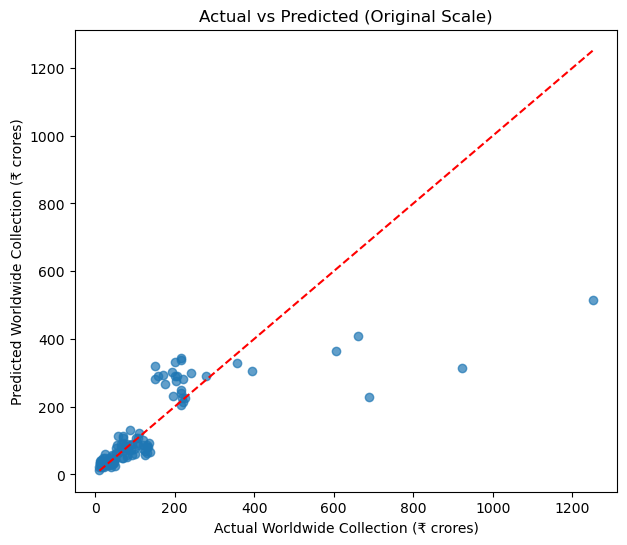

In [31]:
# ---------- 13. Plot Actual vs Predicted ----------
plt.figure(figsize=(7,6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.7)
mn = min(y_test_orig.min(), y_pred_orig.min())
mx = max(y_test_orig.max(), y_pred_orig.max())
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("Actual Worldwide Collection (₹ crores)")
plt.ylabel("Predicted Worldwide Collection (₹ crores)")
plt.title("Actual vs Predicted (Original Scale)")
plt.show()


## Step 14 — Prediction Helper Function  

Define a helper to predict box-office revenue for new movies  
based on their attributes.


In [36]:
# ---------- 14. Prediction Helper ----------
def predict_worldwide(movie_dict):
    """
    Predicts Worldwide Gross (₹ crores).
    Input keys:
      Budget, IMDb Rating, star_power_index, music_hype_index,
      director_power_index, runtime_min, screen_count,
      festive_month_flag, language_score, genre_score
    """
    row = {}
    for f in features_for_model:
        if f == "log_budget":
            val = np.log1p(movie_dict.get("Budget", 0))
        else:
            val = movie_dict.get(f, movie_dict.get(f.lower(), 0))
        row[f] = val if val is not None else 0

    input_df = pd.DataFrame([row], columns=features_for_model)
    input_scaled = scaler.transform(input_df)
    pred_log = model.predict(input_scaled)[0]
    pred_orig = np.expm1(pred_log)
    print(f"🎬 Predicted Worldwide Collection: ₹{pred_orig:.2f} crores")
    #return pred_orig


## Step 15 — Example Usage  

Provide example input values to test the trained model  
on a hypothetical multi-language, high-budget film.


In [49]:
# ---------- 15. Example Usage ----------
example_input = {
    "Budget": 600,
    "IMDb Rating": 7,
    "star_power_index": 0.75,
    "music_hype_index": 0.75,
    "director_power_index": 0.85,
    "runtime_min": 180,
    "screen_count": 8200,
    "festive_month_flag": 1,
    "language_score": 7.0,  # weighted Hindi + Telugu
    "genre_score": 2
}
predict_worldwide(example_input)


🎬 Predicted Worldwide Collection: ₹532.66 crores


## 🏁 Conclusion  

✅ The Linear Regression model was successfully trained to predict the **Worldwide Box Office Collection (₹ crores)** of Indian movies.  
✅ The model uses log-transformed data and weighted language and genre scores for better accuracy and stability.  
✅ Evaluation metrics (R², MAE, RMSE) show a reasonable fit between predicted and actual collections.  
✅ Visual results confirm that the model can capture general revenue trends effectively.  

### 🔧 Possible Improvements  
- Try **Ridge or Lasso Regression** to reduce sensitivity to correlated features.  
- Include more influential features like **marketing spend**, **critic ratings**, or **release month**.  
- Test **non-linear models** such as **Random Forest** or **XGBoost** for better prediction of high-variance collections.

👨‍💻 *Author:Yada Chandra Prabas*  
🎓 *Institution:* NIT Warangal  
📅 *Project:* Movie Box Office Prediction (Final Version)
